In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp
from matplotlib import cm

%matplotlib inline

plt.rc("text", usetex=False)
plt.rc("font", family="sans-serif", size=12)

Reaction functions

In [2]:
def f(R,Ri,rho,rhoi):
    return (1/(1+rho**4))*Ri - R

def g(R,Ri,rho,rhoi):
    return (1/(1+R**4))*rhoi - rho

Method of Lines Discretization of PDE

Code adapted from https://docs.scipy.org/doc/scipy/reference/tutorial/integrate.html#mol

In [3]:
def rdPDE(t, y, D, Di, dx):
    # The vectors R, Ri, rho, rhoi are interleaved in y for computational speed
    # every fourth entry is...
    R = y[0::4]
    Ri = y[1::4]
    rho = y[2::4]
    rhoi = y[3::4]

    # dydt is the return value of this function
    dydt = np.empty_like(y)
    dRdt = dydt[0::4]
    dRidt = dydt[1::4]
    drhodt = dydt[2::4]
    drhoidt = dydt[3::4]

    #Take care of left and right points separately with Neumann conditions
    #Rac
    dRdt[0]    = f(R[0],    Ri[0],    rho[0],    rhoi[0]) +  D * (-2*R[0] + 2*R[1]) / dx**2
    dRdt[1:-1] = f(R[1:-1], Ri[1:-1], rho[1:-1], rhoi[1:-1]) +  D * np.diff(R,2) / dx**2
    dRdt[-1]   = f(R[-1],   Ri[-1],   rho[-1],   rhoi[-1]) +  D * (-2*R[-1] + 2*R[-2]) / dx**2
    
    #Inactive Rac
    dRidt[0]    = -f(R[0],    Ri[0],    rho[0],    rhoi[0]) +  Di * (-2*Ri[0] + 2*Ri[1]) / dx**2
    dRidt[1:-1] = -f(R[1:-1], Ri[1:-1], rho[1:-1], rhoi[1:-1]) +  Di * np.diff(Ri,2) / dx**2
    dRidt[-1]   = -f(R[-1],   Ri[-1],   rho[-1],   rhoi[-1]) +  Di * (-2*Ri[-1] + 2*Ri[-2]) / dx**2

    #Rho
    drhodt[0]    = g(R[0],    Ri[0],    rho[0],    rhoi[0]) +  D * (-2*rho[0] + 2*rho[1]) / dx**2
    drhodt[1:-1] = g(R[1:-1], Ri[1:-1], rho[1:-1], rhoi[1:-1]) +  D * np.diff(rho,2) / dx**2
    drhodt[-1]   = g(R[-1],   Ri[-1],   rho[-1],   rhoi[-1]) +  D * (-2*rho[-1] + 2*rho[-2]) / dx**2

    #Inactive Rho
    drhoidt[0]    = -g(R[0],    Ri[0],    rho[0],    rhoi[0]) +  Di * (-2*rhoi[0] + 2*rhoi[1]) / dx**2
    drhoidt[1:-1] = -g(R[1:-1], Ri[1:-1], rho[1:-1], rhoi[1:-1]) +  Di * np.diff(rhoi,2) / dx**2
    drhoidt[-1]   = -g(R[-1],   Ri[-1],   rho[-1],   rhoi[-1]) +  Di * (-2*rhoi[-1] + 2*rhoi[-2]) / dx**2

    #Compile RHS values into vector
    dydt[0::4] = dRdt
    dydt[1::4] = dRidt
    dydt[2::4] = drhodt
    dydt[3::4] = drhoidt

    return dydt

Set parameters, numerical parameters, and initial conditions

In [4]:
#numerical parameters
N = 500
L = 5
x = np.linspace(0, L, N)
dx = L/N

#model parameters
RT = 2
rhoT = 2
D = 0.1
Di = 10

#steady-states
Rss = 0.81747102
Riss = RT - 0.81747102
rhoss = 0.81747102
rhoiss = rhoT - 0.81747102

#generate initial conditions
R0 = Rss*np.ones(np.size(x)) + 0.01*np.sin(2*np.pi*x)
Ri0 = Riss*np.ones(np.size(x))
rho0 = rhoss*np.ones(np.size(x)) - 0.01*np.sin(np.pi*x)
rhoi0 = rhoiss*np.ones(np.size(x))

#compile ICs into vector
y0 = np.zeros(4*N)
y0[0::4] = R0
y0[1::4] = Ri0
y0[2::4] = rho0
y0[3::4] = rhoi0

Solve ODE system, using lambda function to pass additional arguments (parameters), for time [0, 2000], initial condition y0, method is 'LSODA'. You could also use 'Radau' or 'BDF' since this system is stiff. lband and uband parameters are will only work for LSODA. They describe where the Jacobian is non-zero

In [5]:
%time
sol = solve_ivp(lambda t,y: rdPDE(t, y, D, Di, dx),
                [0, 2000], y0, method='LSODA',lband=4,uband=4)




CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs


Output

In [6]:
t = sol.t
y = sol.y

In [7]:
print(np.shape(t))
print(np.shape(x))
print(np.shape(y))

(92,)
(500,)
(2000, 92)


y is a big matrix:

```
      t0,           t1,           t2,           ...,  t_end
x0    R(x0,t0),     R(x0,t1),     R(x0,t2),     ...,  R(x0,t_end)
x0    R_i(x0,t0),   R_i(x0,t1),   R_i(x0,t2),   ...,  R_i(x0,t_end)
x0    p(x0,t0),     p(x0,t1),     p(x0,t2),     ...,  p(x0,t_end)
x0    p_i(x0,t0),   p_i(x0,t1),   p_i(x0,t2),   ...,  p_i(x0,t_end)

x1    R(x1,t0),     R(x1,t1),     R(x1,t2),     ...,  R(x1,t_end)
x1    R_i(x1,t0),   R_i(x1,t1),   R_i(x1,t2),   ...,  R_i(x1,t_end)
x1    p(x1,t0),     p(x1,t1),     p(x1,t2),     ...,  p(x1,t_end)
x1    p_i(x1,t0),   p_i(x1,t1),   p_i(x1,t2),   ...,  p_i(x1,t_end)

.                                               .
.                                               .
.                                               .

xN-1  R(xN-1,t0),   R(xN-1,t1),   R(xN-1,t2),   ...,  R(xN-1,t_end)
xN-1  R_i(xN-1,t0), R_i(xN-1,t1), R_i(xN-1,t2), ...,  R_i(xN-1,t_end)
xN-1  p(xN-1,t0),   p(xN-1,t1),   p(xN-1,t2),   ...,  p(xN-1,t_end)
xN-1  p_i(xN-1,t0), p_i(xN-1,t1), p_i(xN-1,t2), ...,  p_i(xN-1,t_end)

```


In [8]:
R = y[0::4,:]
Ri = y[1::4,:]
rho = y[2::4,:]
rhoi = y[3::4,:]

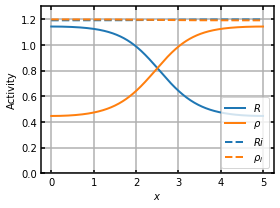

In [9]:
fig = plt.figure("fig1",figsize=(4,3))
ax1 = plt.subplot(111)
ax1.plot(x,R[:,-1],linewidth=2,label=r'$R$')
ax1.plot(x,rho[:,-1],linewidth=2,label=r'$\rho$')
ax1.plot(x,Ri[:,-1],'--',linewidth=2,color='#1f77b4',label=r'$Ri$')
ax1.plot(x,rhoi[:,-1],'--',linewidth=2,color='#ff7f0e',label=r'$\rho_i$')
ax1.tick_params(axis="both", direction="in", which="both", right=True, top=True, labelsize=10 , width=1.5)
ax1.set_xlabel(r'$x$')
ax1.set_ylabel(r'Activity')
ax1.set_ylim((0,1.3))
ax1.grid(linewidth=1.5)
ax1.spines["left"].set_linewidth(1.5)
ax1.spines["top"].set_linewidth(1.5)
ax1.spines["right"].set_linewidth(1.5)
ax1.spines["bottom"].set_linewidth(1.5)
plt.legend(loc=4)
plt.tight_layout()
# plt.savefig('RacRho.tif',dpi=600)
plt.show()

Check for mass conservation

10.0
9.999899078967593
9.99364705932851
9.993544648996112


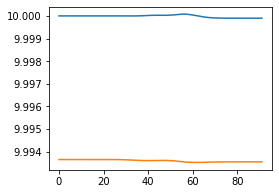

In [10]:
print(np.sum(dx*(R[:,0] + Ri[:,0])))
print(np.sum(dx*(R[:,-1] + Ri[:,-1])))
print(np.sum(dx*(rho[:,0] + rhoi[:,0])))
print(np.sum(dx*(rho[:,-1] + rhoi[:,-1])))
Rmass = []
rhomass = []

for i in range(len(t)):
    Rmass.append(np.sum(dx*(R[:,i] + Ri[:,i])))
    rhomass.append(np.sum(dx*(rho[:,i] + rhoi[:,i])))

plt.figure(figsize=(4,3))
plt.plot(Rmass)
plt.plot(rhomass)
plt.show()

Movie

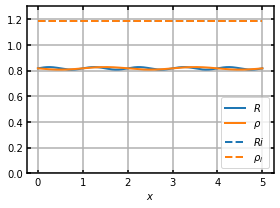

In [11]:
import matplotlib.animation as animation
fig = plt.figure(figsize=(4,3))
ax = plt.subplot(111)
ax.tick_params(axis="both", direction="in", which="both", right=True, top=True, labelsize=10 , width=1.5)
ax.set_xlabel(r'$x$')
# ax.set_ylabel('Activity')
ax.spines["left"].set_linewidth(1.5)
ax.spines["top"].set_linewidth(1.5)
ax.spines["right"].set_linewidth(1.5)
ax.spines["bottom"].set_linewidth(1.5)
# ax.set_xlim(0,1)
ax.set_ylim((0,1.3))
ax.grid(linewidth=1.5)
# title = plt.title(r'$b$=%1.2f, $\delta$=%1.2f' %(b, delta))
line_v, = ax.plot(x,R[:,0],linewidth=2,label=r'$R$')
line_w, = ax.plot(x,rho[:,0],linewidth=2,label=r'$\rho$')
line_vi, = ax.plot(x,Ri[:,0],'--',linewidth=2,color='#1f77b4',label=r'$Ri$')
line_wi, = ax.plot(x,rhoi[:,0],'--',linewidth=2,color='#ff7f0e',label=r'$\rho_i$')
plt.legend(loc=4)
plt.tight_layout()

def animate(i):
    line_v.set_ydata(R[:,i])
    line_w.set_ydata(rho[:,i])
    line_vi.set_ydata(Ri[:,i])
    line_wi.set_ydata(rhoi[:,i])
    return line_v, line_w, line_vi, line_wi

ani = animation.FuncAnimation(fig,animate,frames=np.size(t))
ani.save("RacRho.mp4",fps=30,dpi=300)